<a href="https://colab.research.google.com/github/ProfessorQu/Pytorch-for-Deep-Learning/blob/main/MyOwnGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: quintvu
Your Kaggle Key: ··········


100%|██████████| 96.0M/96.0M [00:01<00:00, 99.1MB/s]


In [3]:
import os

DATA_DIR = './cats-faces-64x64-for-generative-models'
print(os.listdir(DATA_DIR))

['cats']


In [4]:
print(os.listdir(DATA_DIR + '/cats')[:10])

['8993.jpg', '15395.jpg', '825.jpg', '4326.jpg', '906.jpg', '14216.jpg', '13967.jpg', '5170.jpg', '8893.jpg', '132.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


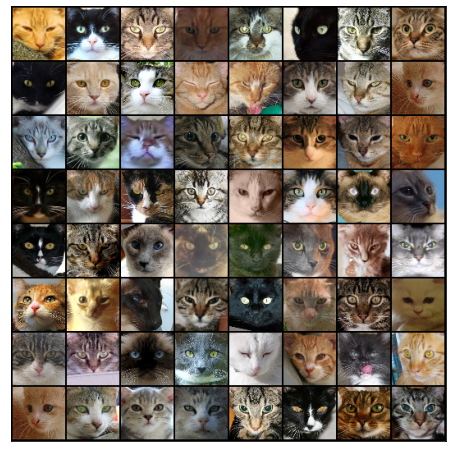

In [11]:
show_batch(train_dl)

# GPU

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator

In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

# Generator

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


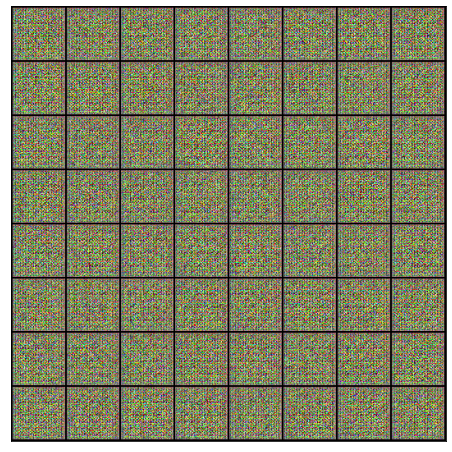

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

# Train Discriminator

In [22]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Train Generator

In [23]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


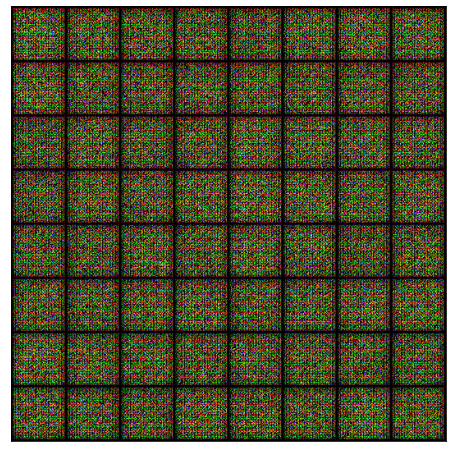

In [28]:
save_samples(0, fixed_latent)

# Full Training Loop

In [29]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002
epochs = 200

In [32]:
history = fit(epochs, lr)

  0%|          | 0/247 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/200], loss_g: 1.8703, loss_d: 3.7808, real_score: 0.0339, fake_score: 0.0075
Saving generated-images-0001.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 1.3972, loss_d: 1.1734, real_score: 0.4292, fake_score: 0.0495
Saving generated-images-0002.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 1.6825, loss_d: 1.2162, real_score: 0.4659, fake_score: 0.2760
Saving generated-images-0003.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 2.3429, loss_d: 0.9528, real_score: 0.6128, fake_score: 0.1001
Saving generated-images-0004.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 1.7358, loss_d: 1.1882, real_score: 0.4874, fake_score: 0.2711
Saving generated-images-0005.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 4.8311, loss_d: 0.3923, real_score: 0.7778, fake_score: 0.0835
Saving generated-images-0006.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 2.2011, loss_d: 0.4650, real_score: 0.7072, fake_score: 0.0811
Saving generated-images-0007.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 4.2604, loss_d: 0.4533, real_score: 0.7150, fake_score: 0.0213
Saving generated-images-0008.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 7.2258, loss_d: 3.4966, real_score: 0.0484, fake_score: 0.0002
Saving generated-images-0009.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 3.8599, loss_d: 0.2975, real_score: 0.8505, fake_score: 0.1138
Saving generated-images-0010.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 6.1052, loss_d: 0.2200, real_score: 0.8145, fake_score: 0.0070
Saving generated-images-0011.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 2.7642, loss_d: 0.4570, real_score: 0.7548, fake_score: 0.0990
Saving generated-images-0012.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 3.9958, loss_d: 0.6514, real_score: 0.8304, fake_score: 0.3267
Saving generated-images-0013.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 8.1444, loss_d: 0.2765, real_score: 0.7882, fake_score: 0.0007
Saving generated-images-0014.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 5.9507, loss_d: 0.2549, real_score: 0.9319, fake_score: 0.1568
Saving generated-images-0015.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 6.8899, loss_d: 0.2871, real_score: 0.9721, fake_score: 0.2131
Saving generated-images-0016.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 9.0376, loss_d: 0.0670, real_score: 0.9382, fake_score: 0.0001
Saving generated-images-0017.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 2.9295, loss_d: 1.2619, real_score: 0.4260, fake_score: 0.0030
Saving generated-images-0018.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 4.3579, loss_d: 0.1176, real_score: 0.9379, fake_score: 0.0451
Saving generated-images-0019.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 5.6522, loss_d: 0.0476, real_score: 0.9745, fake_score: 0.0208
Saving generated-images-0020.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 8.2443, loss_d: 0.4729, real_score: 0.9538, fake_score: 0.3087
Saving generated-images-0021.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 8.1435, loss_d: 0.4124, real_score: 0.9968, fake_score: 0.2921
Saving generated-images-0022.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 4.0077, loss_d: 0.1774, real_score: 0.9259, fake_score: 0.0828
Saving generated-images-0023.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 7.5588, loss_d: 0.0083, real_score: 0.9934, fake_score: 0.0017
Saving generated-images-0024.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 5.5711, loss_d: 0.3441, real_score: 0.7263, fake_score: 0.0007
Saving generated-images-0025.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 6.9591, loss_d: 0.1023, real_score: 0.9093, fake_score: 0.0009
Saving generated-images-0026.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 4.7012, loss_d: 0.0134, real_score: 0.9983, fake_score: 0.0114
Saving generated-images-0027.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 7.2152, loss_d: 0.1853, real_score: 0.9551, fake_score: 0.1244
Saving generated-images-0028.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 6.5345, loss_d: 0.0392, real_score: 0.9649, fake_score: 0.0028
Saving generated-images-0029.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 6.8279, loss_d: 0.0422, real_score: 0.9616, fake_score: 0.0021
Saving generated-images-0030.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 8.2015, loss_d: 0.2665, real_score: 0.9837, fake_score: 0.1955
Saving generated-images-0031.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 4.5716, loss_d: 0.0276, real_score: 0.9903, fake_score: 0.0172
Saving generated-images-0032.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 5.4200, loss_d: 0.1536, real_score: 0.9997, fake_score: 0.1233
Saving generated-images-0033.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 4.3289, loss_d: 0.1430, real_score: 0.9350, fake_score: 0.0644
Saving generated-images-0034.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 5.2751, loss_d: 0.0275, real_score: 0.9903, fake_score: 0.0173
Saving generated-images-0035.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 3.0587, loss_d: 5.1646, real_score: 0.0075, fake_score: 0.0001
Saving generated-images-0036.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 6.8789, loss_d: 0.1277, real_score: 0.9970, fake_score: 0.1097
Saving generated-images-0037.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 5.4994, loss_d: 0.0897, real_score: 0.9194, fake_score: 0.0008
Saving generated-images-0038.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 3.9161, loss_d: 0.0834, real_score: 0.9646, fake_score: 0.0443
Saving generated-images-0039.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 7.9070, loss_d: 0.0631, real_score: 0.9427, fake_score: 0.0010
Saving generated-images-0040.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 4.8847, loss_d: 0.0830, real_score: 0.9461, fake_score: 0.0240
Saving generated-images-0041.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 1.8719, loss_d: 0.1559, real_score: 0.8928, fake_score: 0.0377
Saving generated-images-0042.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 4.7806, loss_d: 0.8615, real_score: 0.6327, fake_score: 0.2671
Saving generated-images-0043.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 4.1962, loss_d: 0.0857, real_score: 0.9897, fake_score: 0.0647
Saving generated-images-0044.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 2.2274, loss_d: 0.2920, real_score: 0.8462, fake_score: 0.0760
Saving generated-images-0045.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 10.5643, loss_d: 0.4375, real_score: 0.7491, fake_score: 0.0001
Saving generated-images-0046.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 4.0421, loss_d: 0.3537, real_score: 0.7620, fake_score: 0.0147
Saving generated-images-0047.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 3.0763, loss_d: 0.2162, real_score: 0.9378, fake_score: 0.1194
Saving generated-images-0048.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 6.0543, loss_d: 0.1360, real_score: 0.9729, fake_score: 0.0860
Saving generated-images-0049.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 5.4904, loss_d: 0.0057, real_score: 0.9988, fake_score: 0.0045
Saving generated-images-0050.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 1.7726, loss_d: 0.6636, real_score: 0.6420, fake_score: 0.0041
Saving generated-images-0051.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 6.1517, loss_d: 0.1843, real_score: 0.9833, fake_score: 0.1381
Saving generated-images-0052.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 10.5630, loss_d: 0.0689, real_score: 0.9353, fake_score: 0.0003
Saving generated-images-0053.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 3.7688, loss_d: 1.2005, real_score: 0.4807, fake_score: 0.0037
Saving generated-images-0054.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 5.5728, loss_d: 0.0977, real_score: 0.9522, fake_score: 0.0349
Saving generated-images-0055.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 5.2535, loss_d: 0.0150, real_score: 0.9969, fake_score: 0.0117
Saving generated-images-0056.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 5.4103, loss_d: 0.0217, real_score: 0.9842, fake_score: 0.0056
Saving generated-images-0057.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 5.6334, loss_d: 0.0462, real_score: 0.9960, fake_score: 0.0367
Saving generated-images-0058.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 5.9963, loss_d: 0.0089, real_score: 0.9954, fake_score: 0.0043
Saving generated-images-0059.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 1.3604, loss_d: 1.4799, real_score: 0.4013, fake_score: 0.0067
Saving generated-images-0060.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 4.2698, loss_d: 0.4908, real_score: 0.7394, fake_score: 0.0073
Saving generated-images-0061.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 2.8682, loss_d: 1.7407, real_score: 0.2726, fake_score: 0.0006
Saving generated-images-0062.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 3.5427, loss_d: 0.0870, real_score: 0.9454, fake_score: 0.0280
Saving generated-images-0063.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 3.6205, loss_d: 0.5081, real_score: 0.7747, fake_score: 0.1784
Saving generated-images-0064.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 5.8672, loss_d: 0.0422, real_score: 0.9755, fake_score: 0.0168
Saving generated-images-0065.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 3.8640, loss_d: 0.0780, real_score: 0.9969, fake_score: 0.0674
Saving generated-images-0066.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 4.7248, loss_d: 0.0718, real_score: 0.9996, fake_score: 0.0591
Saving generated-images-0067.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 8.7792, loss_d: 0.4628, real_score: 0.9509, fake_score: 0.2834
Saving generated-images-0068.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 5.1619, loss_d: 0.0372, real_score: 0.9710, fake_score: 0.0071
Saving generated-images-0069.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 3.3573, loss_d: 0.2851, real_score: 0.8197, fake_score: 0.0099
Saving generated-images-0070.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 6.6115, loss_d: 0.0494, real_score: 0.9954, fake_score: 0.0357
Saving generated-images-0071.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 4.3015, loss_d: 0.2006, real_score: 0.8619, fake_score: 0.0067
Saving generated-images-0072.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 4.7498, loss_d: 0.0630, real_score: 0.9701, fake_score: 0.0306
Saving generated-images-0073.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 2.1307, loss_d: 0.6244, real_score: 0.6381, fake_score: 0.0025
Saving generated-images-0074.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 5.7941, loss_d: 1.1226, real_score: 0.7121, fake_score: 0.3002
Saving generated-images-0075.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 3.6595, loss_d: 0.1473, real_score: 0.8964, fake_score: 0.0310
Saving generated-images-0076.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 6.6329, loss_d: 0.0443, real_score: 0.9611, fake_score: 0.0031
Saving generated-images-0077.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 4.4591, loss_d: 0.0967, real_score: 0.9370, fake_score: 0.0287
Saving generated-images-0078.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 7.0196, loss_d: 0.0060, real_score: 0.9959, fake_score: 0.0019
Saving generated-images-0079.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 0.3498, loss_d: 0.5026, real_score: 0.6421, fake_score: 0.0089
Saving generated-images-0080.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 4.1853, loss_d: 0.1791, real_score: 0.8514, fake_score: 0.0101
Saving generated-images-0081.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 3.3243, loss_d: 0.1980, real_score: 0.8711, fake_score: 0.0413
Saving generated-images-0082.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 4.6737, loss_d: 0.0672, real_score: 0.9645, fake_score: 0.0285
Saving generated-images-0083.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 3.8356, loss_d: 1.7958, real_score: 0.3109, fake_score: 0.0036
Saving generated-images-0084.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 3.3350, loss_d: 0.2300, real_score: 0.8419, fake_score: 0.0398
Saving generated-images-0085.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 0.7116, loss_d: 0.4592, real_score: 0.7193, fake_score: 0.0346
Saving generated-images-0086.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 3.9569, loss_d: 0.2191, real_score: 0.9000, fake_score: 0.0982
Saving generated-images-0087.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 4.8555, loss_d: 0.9442, real_score: 0.7551, fake_score: 0.2875
Saving generated-images-0088.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 5.7837, loss_d: 0.1533, real_score: 0.9983, fake_score: 0.1257
Saving generated-images-0089.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 2.0888, loss_d: 0.2932, real_score: 0.8019, fake_score: 0.0458
Saving generated-images-0090.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 0.5427, loss_d: 0.6492, real_score: 0.6100, fake_score: 0.0448
Saving generated-images-0091.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 5.6917, loss_d: 0.1296, real_score: 0.9983, fake_score: 0.1104
Saving generated-images-0092.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 3.1287, loss_d: 0.1553, real_score: 0.9052, fake_score: 0.0373
Saving generated-images-0093.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 5.9752, loss_d: 0.0329, real_score: 0.9946, fake_score: 0.0263
Saving generated-images-0094.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 1.0848, loss_d: 0.4968, real_score: 0.7157, fake_score: 0.0721
Saving generated-images-0095.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 5.6622, loss_d: 0.2155, real_score: 0.8449, fake_score: 0.0058
Saving generated-images-0096.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 4.3280, loss_d: 0.0516, real_score: 0.9779, fake_score: 0.0271
Saving generated-images-0097.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 0.5068, loss_d: 0.2553, real_score: 0.7990, fake_score: 0.0106
Saving generated-images-0098.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 6.2136, loss_d: 0.1320, real_score: 0.9983, fake_score: 0.1039
Saving generated-images-0099.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 0.0226, loss_d: 1.0862, real_score: 0.4552, fake_score: 0.0803
Saving generated-images-0100.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 7.9998, loss_d: 0.0213, real_score: 0.9838, fake_score: 0.0047
Saving generated-images-0101.png


  0%|          | 0/247 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [33]:
losses_g, losses_d, real_scores, fake_scores = history

NameError: ignored

In [34]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [35]:
from IPython.display import Image

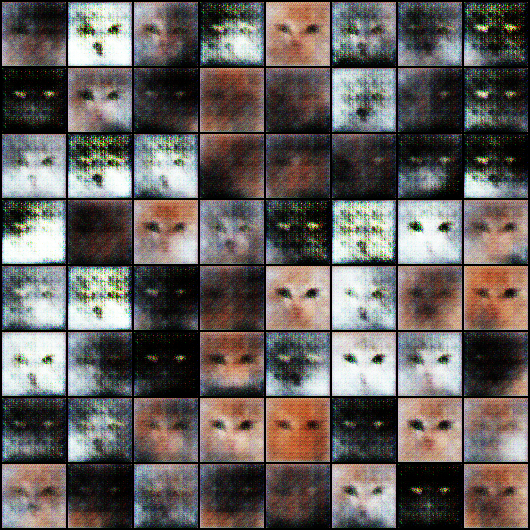

In [36]:
Image('./generated/generated-images-0001.png')

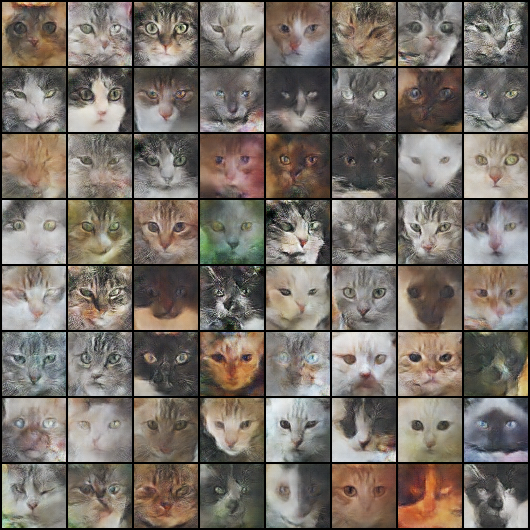

In [37]:
Image('./generated/generated-images-0050.png')

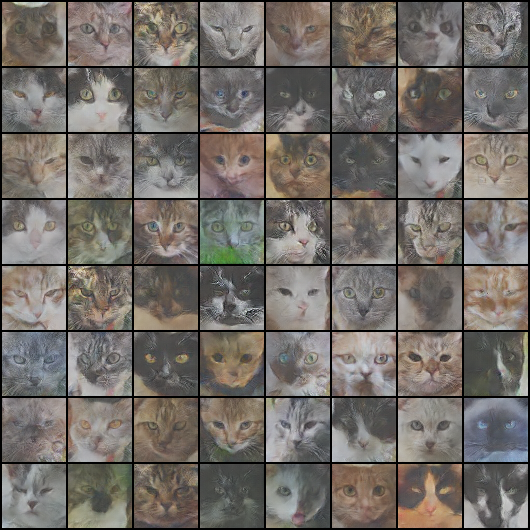

In [38]:
Image('./generated/generated-images-0100.png')

In [39]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [40]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

NameError: ignored

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [41]:
sample_dir = 'manual'
os.makedirs(sample_dir, exist_ok=True)

In [70]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    fake_images = denorm(fake_images)
    fake_images = T.functional.adjust_brightness(fake_images, 1)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-1001.png


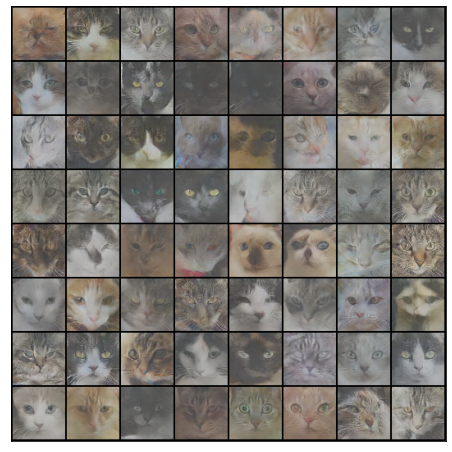

In [78]:
latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(1001, latent)